# MACD Strategy

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import LeaveOneOut, cross_val_predict
from sklearn.naive_bayes import GaussianNB

In [3]:
np.random.seed(42)

In [ ]:
def compute_rsi(df, window=14):
    delta = df['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi


def calculate_momentum(data, window=14):
    momentum = data['Close'].diff(window)
    return momentum


def get_z_score(series, window):
    """Calculate the z-score of a series over a rolling window."""
    return (series - series.rolling(window).mean()) / series.rolling(window).std()


def get_max_posneg_ratio(df):
    max_posneg_ratios = []
    
    for i in range(len(df)):
        pos_ratio = df['positive_ratio'].iloc[i]
        neg_ratio = df['negative_ratio'].iloc[i]
        
        if pos_ratio != neg_ratio:
            
            if pos_ratio > neg_ratio:
                max_posneg_ratios.append(pos_ratio)
            else:
                max_posneg_ratios.append(-1*neg_ratio)
                
        else:
            max_posneg_ratios.append(0)
            
    max_posneg_ratios = np.array(max_posneg_ratios)
    return max_posneg_ratios


def get_log_pos_neg_ratio(df):
    log_pos_neg_ratios = []
    
    for i in range(len(df)):
        pos_neg_ratio = df['pos/neg_ratio'].iloc[i]
        if pos_neg_ratio != 0:
            log_pos_neg_ratios.append(np.log(pos_neg_ratio))
        else:
            log_pos_neg_ratios.append(0)
    log_pos_neg_ratios = np.array(log_pos_neg_ratios)
    return log_pos_neg_ratios


def calculate_sharpe_ratio(daily_returns, annual_risk_free_rate=0.05, mode='252'):
    """
    Calculate the Sharpe Ratio of a portfolio.
    
    Parameters:
    daily_returns (pd.Series): Daily returns of the portfolio.
    annual_risk_free_rate (float): Annual risk-free rate (default is 5%).
    mode (str): '365' for daily returns, '252' for trading days (default is '252').
    
    Returns:
    float: Sharpe Ratio.
    """
    if mode == '365':
        risk_free_rate = annual_risk_free_rate / 365
        excess_daily_returns = daily_returns - risk_free_rate
        sharpe_ratio = np.sqrt(365) * excess_daily_returns.mean() / excess_daily_returns.std()
    elif mode == '252':
        risk_free_rate = annual_risk_free_rate / 252
        excess_daily_returns = daily_returns - risk_free_rate
        sharpe_ratio = np.sqrt(252) * excess_daily_returns.mean() / excess_daily_returns.std()
    else:
        raise ValueError("Invalid mode. Use '365' for daily returns or '252' for trading days.")
    
    return sharpe_ratio


def simulate_strategy(df, initial_cash=100_000, hold_days=14, trading_fee=0.001, signal_col='Signal'):
    cash = initial_cash
    shares = 0
    position_open = False
    entry_index = None
    position_type = None  # Can be 'long' or 'short'
    entry_indices = []

    portfolio_values = []

    for i in range(len(df)):
        current_price = df.iloc[i]['Close']
        signal = df.iloc[i][signal_col]

        # Close long position after hold_days
        if position_open and position_type == 'long' and (i - entry_index >= hold_days):
            cash = shares * current_price * (1 - trading_fee)  # deduct trading fee
            shares = 0
            position_open = False
            position_type = None

        # Close short position after hold_days
        elif position_open and position_type == 'short' and (i - entry_index >= hold_days):
            cost_to_close = shares * current_price
            cash += (initial_cash - cost_to_close)  # profit/loss from shorting
            shares = 0
            position_open = False
            position_type = None

        # Open long position
        if not position_open and signal == 1:
            shares = cash / (current_price*(1 + trading_fee))  # buy shares
            cash = 0
            position_open = True
            entry_index = i
            position_type = 'long'

        # Open short position
        elif not position_open and signal == -1:
            shares = cash / current_price  # simulate shorting by "borrowing" shares
            position_open = True
            entry_index = i
            position_type = 'short'
            # Keep cash as it is — you receive it from selling the borrowed shares

        # Calculate portfolio value
        if position_open:
            if position_type == 'long':
                portfolio_value = shares * current_price
            elif position_type == 'short':
                # Unrealized value: assume you need to buy back the borrowed shares
                cost_to_close = shares * current_price
                portfolio_value = cash + (initial_cash - cost_to_close)
        else:
            portfolio_value = cash

        entry_indices.append({entry_index:position_type})
        portfolio_values.append(portfolio_value)

    df['portfolio_value'] = portfolio_values
    return df, entry_indices


## General loop through the windows and models

In [ ]:
H = 7
delta = 5
windows = [10, 15, 20]
fast, slow, signal = 8, 17, 5

results = {
    "NaiveBayes": {10: None, 15: None, 20: None},
    "RidgeLogit": {10: None, 15: None, 20: None},
    "RandomForest": {10: None, 15: None, 20: None},
    "MACD_Baseline": {10: None, 15: None, 20: None}
}

equity_curves = {'10':{
                        'NaiveBayes': None,
                        'RidgeLogit': None,
                        'RandomForest': None,
                        'MACD_Baseline': None,
                        'Date': None
},
                 '15':{
                        'NaiveBayes': None,
                        'RidgeLogit': None,
                        'RandomForest': None,
                        'MACD_Baseline': None,
                        'Date': None
},
                 '20':{
                        'NaiveBayes': None,
                        'RidgeLogit': None,
                        'RandomForest': None,
                        'MACD_Baseline': None,
                        'Date': None
}
}

portfolios = {
    "10": {
        "NaiveBayes": None,
        "RidgeLogit": None,
        "RandomForest": None,
        "MACD_Baseline": None
    },
    "15": {
        "NaiveBayes": None,
        "RidgeLogit": None,
        "RandomForest": None,
        "MACD_Baseline": None
    },
    "20": {
        "NaiveBayes": None,
        "RidgeLogit": None,
        "RandomForest": None,
        "MACD_Baseline": None
    }
}

trade_indices = {
    "10": {
        "NaiveBayes": None,
        "RidgeLogit": None,
        "RandomForest": None,
        "MACD_Baseline": None
    },
    "15": {
        "NaiveBayes": None,
        "RidgeLogit": None,
        "RandomForest": None,
        "MACD_Baseline": None
    },
    "20": {
        "NaiveBayes": None,
        "RidgeLogit": None,
        "RandomForest": None,
        "MACD_Baseline": None
    }
}

for w in windows:
    daily_entry_df = pd.read_csv('./daily_entry_df.csv')
    daily_entry_df.rename(columns={'date': 'Date'}, inplace=True)
    daily_entry_df['Date'] = pd.to_datetime(daily_entry_df['Date'])
    daily_entry_df['Date'] = daily_entry_df['Date'].dt.date

    log_pos_neg_ratios = get_log_pos_neg_ratio(daily_entry_df)
    daily_entry_df['log_pos/neg_ratio'] = log_pos_neg_ratios


    daily_entry_df['activity'] = daily_entry_df['total'] 
    daily_entry_df[f'{delta}_day_activity_pct_change'] = daily_entry_df['total'].pct_change(periods=delta)
    daily_entry_df[f'activity_z{w}'] = get_z_score(daily_entry_df['total'], w)
    #df3[f'activity_MA_{MA}'] = df2['total'] - df2['total'].rolling(MA).mean()

    #daily_entry_df['polarity'] = (daily_entry_df['total'] / (daily_entry_df['total'] + 317)) * daily_entry_df['polarity_raw'] #changed
    daily_entry_df[f'{delta}_day_delta_polarity'] = daily_entry_df['polarity'].diff(periods=delta)
    daily_entry_df[f'{w}_day_z_score_polarity'] = (daily_entry_df['polarity'] - daily_entry_df['polarity'].rolling(w).mean()) / daily_entry_df['polarity'].rolling(w).std()
    #df3[f'polarity_MA_{MA}'] = df3['polarity'] - df3['polarity'].rolling(MA).mean()

    max_posneg_ratios = get_max_posneg_ratio(daily_entry_df)
    daily_entry_df['max_posneg_ratio'] = max_posneg_ratios

    daily_entry_df['polarity_x_activity'] = daily_entry_df['polarity'] * np.log1p(daily_entry_df['activity']) #changed
    daily_entry_df['polarity_t-1'] = daily_entry_df['polarity'].shift(1)
    daily_entry_df['polarity_t-2'] = daily_entry_df['polarity'].shift(2)
    
    BTC = pd.read_csv('BTC-USD.csv', header=[0, 1, 2])
    df = BTC.copy()
    df.columns = ['Date', 'Close', 'Open', 'High', 'Low', 'Volume']
    df['Date'] = pd.to_datetime(df['Date'])
    df['Date'] = df['Date'].dt.date
    df = df[['Close', 'Open', 'Volume', 'Date']]
    df.columns = ['Close', 'Open', 'Volume', 'Date'] # get rid of the annoying index header
    df[f'Close_z{w}'] = get_z_score(df['Close'], w)
    df[f'{delta}_day_returns'] = df['Close'].pct_change(periods=delta)  # returns for the past 5 days
    df[f'Close-MA_{w}'] = df['Close'] - df['Close'].rolling(w).mean()
    df[f'Open_Close_diff'] = df['Open'] - df['Close']

    df[f'Volume_z{w}'] = get_z_score(df['Volume'], w) 
    #df3[f'{delta}_day_volume_returns'] = df2['Volume'].pct_change(periods=delta)  # returns for the past 5 days
    df[f'{delta}_Day_Delta_Volume'] = df['Volume'].diff(periods=delta)
    df[f'Volume-MA_{w}'] = df['Volume'] - df['Volume'].rolling(w).mean()

    #df3['OBV'] = df2['OBV']
    df['RSI'] = compute_rsi(df, window=w)
    df[f'{delta}_Day_Delta_RSI'] = df['RSI'].diff(periods=delta)
    df['RSI-50'] = df['RSI'] - 50

    df['Momentum'] = df['Close'].diff(periods=w)
    df[f'{delta}_Day_Delta_Momentum'] = df['Momentum'].diff(periods=delta)
    #df3[f'{delta}_day_momentum_pct_change'] = df2['Momentum'].pct_change(periods=delta)

    df[f'{w}_day_volatility'] = df['Close'].rolling(w).std()
    
    df['ema_fast']   = df['Close'].ewm(span=fast).mean()
    df['ema_slow']   = df['Close'].ewm(span=slow).mean()
    df['macd']       = df['ema_fast'] - df['ema_slow']
    df['macd_signal'] = df['macd'].ewm(span=signal).mean()
    df['macd_diff']   = df['macd'] - df['macd_signal']

    # Target variable
    df[f"ret_fwd_{H}d"] = df['Close'].pct_change(periods=H).shift(-H)            

    # Baseline A long/flat rule: go long when MACD crosses up
    df['macd_cross_up'] = (df['macd_diff'].shift(1) < 0) & (df['macd_diff'] > 0)
    
    df3 = pd.merge(daily_entry_df, df, on='Date', how='inner') 
    df3.drop(columns=['total', 'positive', 'negative', 'neutral', 'pos/neg_ratio', 'positive_ratio', 'negative_ratio', 'RSI', 'Volume', 'Open'], inplace=True)
    df3.dropna(inplace=True)
    df3.reset_index(drop=True, inplace=True)
    
    macd_df = df3.copy()

    gate_df = macd_df.loc[macd_df['macd_cross_up']].copy()
    gate_df['y_gate'] = (gate_df[f"ret_fwd_{H}d"] > 0).astype(int)
    
    cols = [
    f'{w}_day_z_score_polarity',
    f'{delta}_day_delta_polarity',                                
    f'activity_z{w}',  
    'polarity_t-1',
    'polarity_t-2',
    f'{delta}_day_activity_pct_change',
    ]
    X = gate_df[cols]
    y = gate_df['y_gate']       
    
    gnb = GaussianNB()
    ridge = LogisticRegression(penalty='l2', C=1.0, solver='lbfgs')
    pipe = make_pipeline( 
        RandomForestClassifier(random_state=42, max_depth=3, min_samples_leaf=16, n_estimators=200, class_weight='balanced'))

    loo = LeaveOneOut()
    p_hat = cross_val_predict(pipe, X, y, cv=loo, method='predict_proba')[:, 1]
    p_hat_gnb = cross_val_predict(gnb, X, y, cv=loo, method='predict_proba')[:, 1]
    p_hat_ridge = cross_val_predict(ridge, X, y, cv=loo, method='predict_proba')[:, 1]
    
    gate_df['pass'] = (p_hat > 0.50).astype(int)
    gate_df['pass_gnb'] = (p_hat_gnb > 0.50).astype(int)
    gate_df['pass_ridge'] = (p_hat_ridge > 0.50).astype(int)
    
    y_pred_gate = gate_df['pass'].values
    y_pred_gate_gnb = gate_df['pass_gnb'].values
    y_pred_gate_ridge = gate_df['pass_ridge'].values
    y_true_gate = gate_df['y_gate'].values

    results['NaiveBayes'][w] = (y_true_gate, y_pred_gate_gnb)
    results['RidgeLogit'][w] = (y_true_gate, y_pred_gate_ridge)
    results['RandomForest'][w] = (y_true_gate, y_pred_gate)
    results['MACD_Baseline'][w] = (y_true_gate, np.ones_like(y_true_gate))
    
    sim_df = pd.merge(df, gate_df[['Date', 'y_gate', 'pass', 'pass_gnb', 'pass_ridge']], on='Date', how='left')
    sim_df['pass'].fillna(0, inplace=True)
    sim_df['pass_gnb'].fillna(0, inplace=True)
    sim_df['pass_ridge'].fillna(0, inplace=True)
    sim_df['y_gate'].fillna(0, inplace=True)
    sim_df['y_gate'] = sim_df['y_gate'].astype(int)

    sim_df['Signal_gate'] = sim_df['pass'].shift(1)
    sim_df['Signal_gate_gnb'] = sim_df['pass_gnb'].shift(1)
    sim_df['Signal_gate_ridge'] = sim_df['pass_ridge'].shift(1)
    sim_df['Signal_macd'] = sim_df['macd_cross_up'].shift(1)
    sim_df['Signal_gate'].fillna(0, inplace=True)
    sim_df['Signal_gate_gnb'].fillna(0, inplace=True)
    sim_df['Signal_gate_ridge'].fillna(0, inplace=True)
    sim_df['Signal_macd'].fillna(0, inplace=True)

    sim_df.dropna(inplace=True)
    sim_df.reset_index(drop=True, inplace=True)
    
    gated_df = sim_df.copy()
    gate_df_gnb = sim_df.copy()
    gate_df_ridge = sim_df.copy()
    
    gate_portfolio, gate_entry_indices = simulate_strategy(gated_df, initial_cash=100_000, hold_days=H, trading_fee=0.00075, signal_col='Signal_gate')
    macd_portfolio, macd_entry_indices = simulate_strategy(sim_df, initial_cash=100_000, hold_days=H, trading_fee=0.00075, signal_col='Signal_macd')
    gnb_portfolio, gnb_entry_indices = simulate_strategy(gate_df_gnb, initial_cash=100_000, hold_days=H, trading_fee=0.00075, signal_col='Signal_gate_gnb')
    ridge_portfolio, ridge_entry_indices = simulate_strategy(gate_df_ridge, initial_cash=100_000, hold_days=H, trading_fee=0.00075, signal_col='Signal_gate_ridge')
    
    trade_indices_macd = set()
    for element in macd_entry_indices:
        for key, value in element.items():
            trade_indices_macd.add(key)
            
    trade_indices_gnb = set()
    for element in gnb_entry_indices:
        for key, value in element.items():
            trade_indices_gnb.add(key)
            
    trade_indices_ridge = set()
    for element in ridge_entry_indices:
        for key, value in element.items():
            trade_indices_ridge.add(key)
            
    trade_indices_gate = set()
    for element in gate_entry_indices:
        for key, value in element.items():
            trade_indices_gate.add(key)
            
    trade_indices_macd.discard(None)
    trade_indices_gate.discard(None)
    trade_indices_gnb.discard(None)
    trade_indices_ridge.discard(None)
    
    trade_indices_macd = sorted(list(trade_indices_macd))
    trade_indices_gate = sorted(list(trade_indices_gate))
    trade_indices_gnb = sorted(list(trade_indices_gnb))
    trade_indices_ridge = sorted(list(trade_indices_ridge))

    equity_curves[str(w)]['NaiveBayes'] = gnb_portfolio['portfolio_value']
    equity_curves[str(w)]['RidgeLogit'] = ridge_portfolio['portfolio_value']
    equity_curves[str(w)]['RandomForest'] = gate_portfolio['portfolio_value']
    equity_curves[str(w)]['MACD_Baseline'] = macd_portfolio['portfolio_value']
    equity_curves[str(w)]['Date'] = pd.to_datetime(gate_portfolio['Date']).dt.date
    
    portfolios[str(w)]['NaiveBayes'] = gnb_portfolio
    portfolios[str(w)]['RidgeLogit'] = ridge_portfolio
    portfolios[str(w)]['RandomForest'] = gate_portfolio
    portfolios[str(w)]['MACD_Baseline'] = macd_portfolio
    
    trade_indices[str(w)]['NaiveBayes'] = trade_indices_gnb
    trade_indices[str(w)]['RidgeLogit'] = trade_indices_ridge
    trade_indices[str(w)]['RandomForest'] = trade_indices_gate
    trade_indices[str(w)]['MACD_Baseline'] = trade_indices_macd

/var/folders/qc/7382bn3j7vq46cnb3_4lsqk40000gn/T/ipykernel_913/3596515892.py:191: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  sim_df['pass'].fillna(0, inplace=True)
/var/folders/qc/7382bn3j7vq46cnb3_4lsqk40000gn/T/ipykernel_913/3596515892.py:192: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves

In [6]:
starts = [eq['Date'].iloc[0]      for eq in equity_curves.values()]
ends   = [eq['Date'].iloc[-1]     for eq in equity_curves.values()]

common_start = max(starts)
common_end = min(ends)

### Class Distribution Plot

/var/folders/qc/7382bn3j7vq46cnb3_4lsqk40000gn/T/ipykernel_913/279335284.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


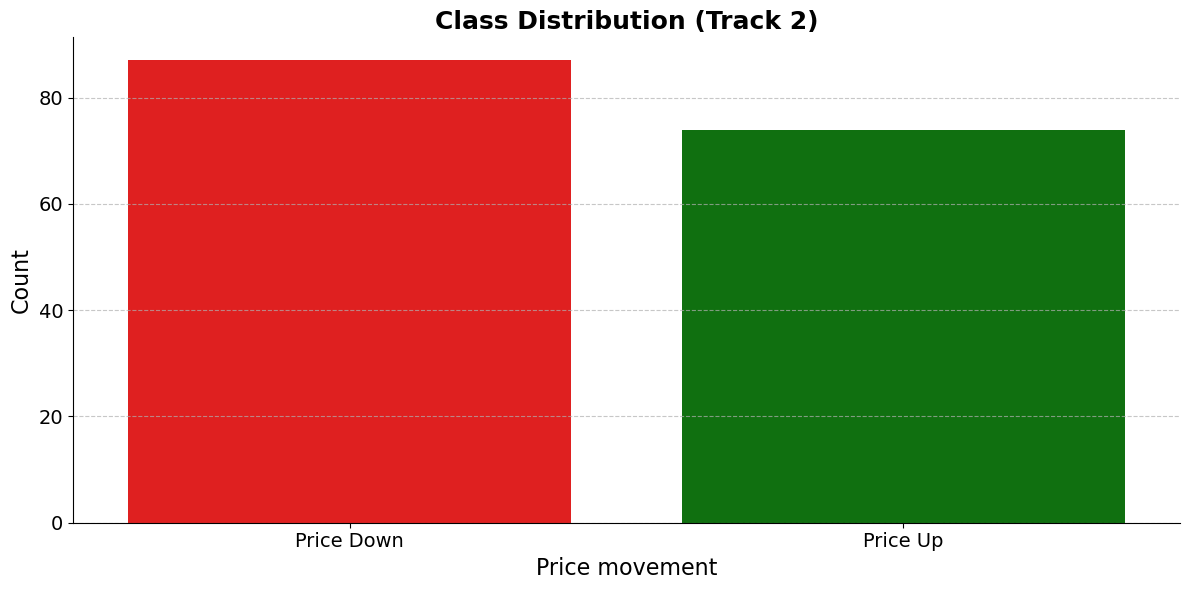

In [7]:
plt.figure(figsize=(12, 6))
plt.title("Class Distribution (Track 2)", fontsize=18, weight='bold')

sns.countplot(
    data=gate_df,
    x='y_gate',
    palette={'0': 'red', '1': 'green'}
)

plt.xlabel('Price movement', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.xticks(ticks=[0, 1], labels=['Price Down', 'Price Up'], fontsize=14)
plt.yticks(fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
sns.despine()
plt.show()

### Precision / Recall / F1 Plot

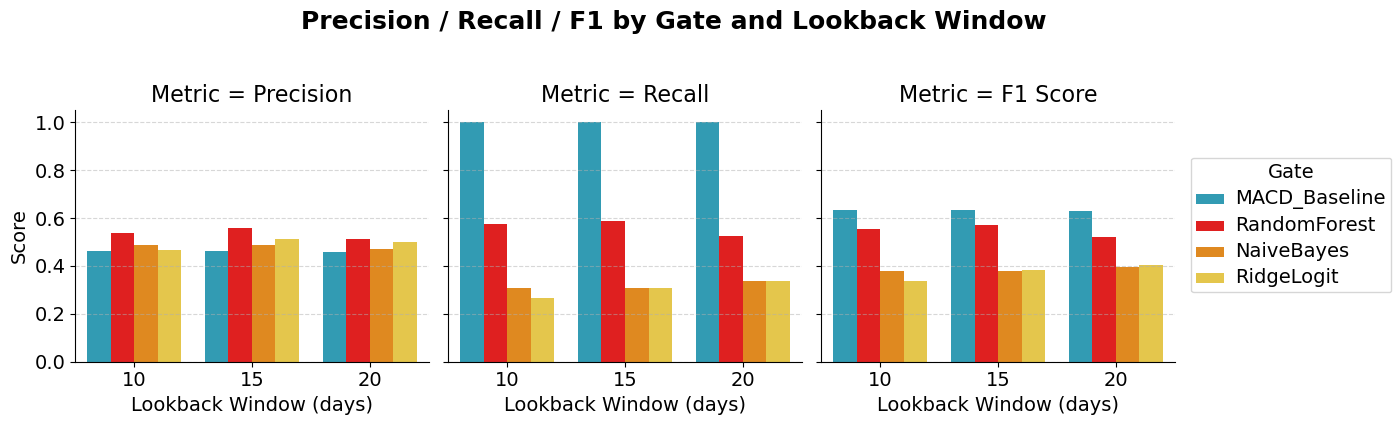

In [ ]:
# Setup
gates   = ['MACD_Baseline', 'NaiveBayes', 'RidgeLogit', 'RandomForest']
windows = [10, 15, 20]

# Collect long-form data
rows = []
for gate in gates:
    for window in windows:
        y_true, y_pred = results[gate][window]
        rows.extend([
            {"Gate": gate, "Window": window, "Metric": "Precision", "Score": precision_score(y_true, y_pred)},
            {"Gate": gate, "Window": window, "Metric": "Recall",    "Score": recall_score(y_true, y_pred)},
            {"Gate": gate, "Window": window, "Metric": "F1 Score",  "Score": f1_score(y_true, y_pred)},
        ])

df = pd.DataFrame(rows)
df['Window'] = pd.Categorical(df['Window'], categories=windows, ordered=True)

# Custom, high-contrast palette
gate_palette = {
    'MACD_Baseline': '#1CA9C9',  # ocean blue
    'NaiveBayes':    '#FF8C00',  # rich orange
    'RidgeLogit':    "#FED532",  # vivid yellow
    'RandomForest':  '#FF0000',  # pure red
}

# Define the exact hue order you want
hue_order = ['MACD_Baseline', 'RandomForest', 'NaiveBayes', 'RidgeLogit']

# Create the faceted barplots
g = sns.catplot(
    data=df,
    x="Window", y="Score",
    hue="Gate",
    hue_order=hue_order,
    col="Metric",
    kind="bar",
    palette=gate_palette,
    height=4, aspect=1
)

# Set titles, labels, font sizes
for ax in g.axes.flat:
    ax.set_title(ax.get_title(), fontsize=16)
    ax.set_xlabel("Lookback Window (days)", fontsize=14)
    ax.set_ylabel("Score", fontsize=14)
    ax.tick_params(axis='x', labelsize=14)
    ax.tick_params(axis='y', labelsize=14)
    ax.grid(axis='y', linestyle='--', alpha=0.5)

# Move legend outside the last subplot (to the right)
g._legend.set_title("Gate", prop={'size': 14})
for text in g._legend.texts:
    text.set_fontsize(14)
g._legend.set_bbox_to_anchor((1.03, 0.5))  # move legend to right side
g._legend.set_frame_on(True)

# Add overall title
g.fig.suptitle("Precision / Recall / F1 by Gate and Lookback Window", fontsize=18, weight='bold', y=1.05)

# Leave space for legend on the right
plt.tight_layout(rect=[0, 0, 0.88, 1])  # shrink the plot area a bit on the right
plt.show()

### Tradeoff plot

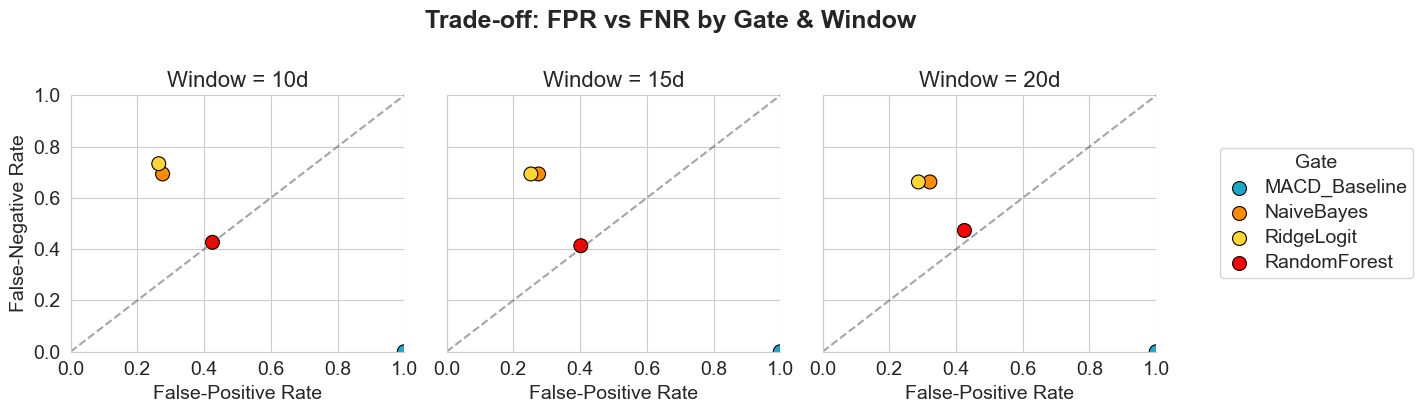

In [ ]:
# 1) Compute FPR & FNR
gates   = ['MACD_Baseline','NaiveBayes','RidgeLogit','RandomForest']
windows = [10, 15, 20]

records = []
for gate in gates:
    for window in windows:
        y_true, y_pred = results[gate][window]
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        fpr = fp / (fp + tn) if (fp + tn) else 0
        fnr = fn / (fn + tp) if (fn + tp) else 0
        records.append({
            'Gate': gate,
            'Window': f"{window}d",
            'FPR': fpr,
            'FNR': fnr
        })

df_rates = pd.DataFrame(records)

# 2) Plot: FPR vs FNR, facet by window
sns.set_style("whitegrid")
g = sns.relplot(
    data=df_rates,
    x="FPR", y="FNR",
    hue="Gate",
    palette={
        'MACD_Baseline':'#1CA9C9',
        'RandomForest':'#FF0000',
        'NaiveBayes':'#FF8C00',
        'RidgeLogit':"#FED532"
    },
    col="Window",
    kind="scatter",
    edgecolor='black',
    linewidth=0.8,
    s=100,
    height=4, aspect=1
)

# 3) Tidy up
for ax in g.axes.flatten():
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.plot([0,1],[0,1], ls="--", c=".3", alpha=0.5)
    ax.set_xlabel("False-Positive Rate", fontsize=14)
    ax.set_ylabel("False-Negative Rate", fontsize=14)
    ax.tick_params(labelsize=14)

# Manually set the column titles (facet titles) to fontsize 16
for ax in g.axes.flatten():
    title = ax.get_title()
    ax.set_title(title, fontsize=16)

# Super-title
g.fig.suptitle("Trade-off: FPR vs FNR by Gate & Window", fontsize=18, weight="bold", y=1.02)

# Legend outside the third plot
g._legend.set_title("Gate", prop={'size': 14})
g._legend.set_bbox_to_anchor((1.05, 0.5))
g._legend.set_frame_on(True)

# Set legend label font size
for text in g._legend.texts:
    text.set_fontsize(14)

# Adjust layout
plt.tight_layout(rect=[0, 0, 0.88, 1])
plt.show()

### Simulated Strategies Plot

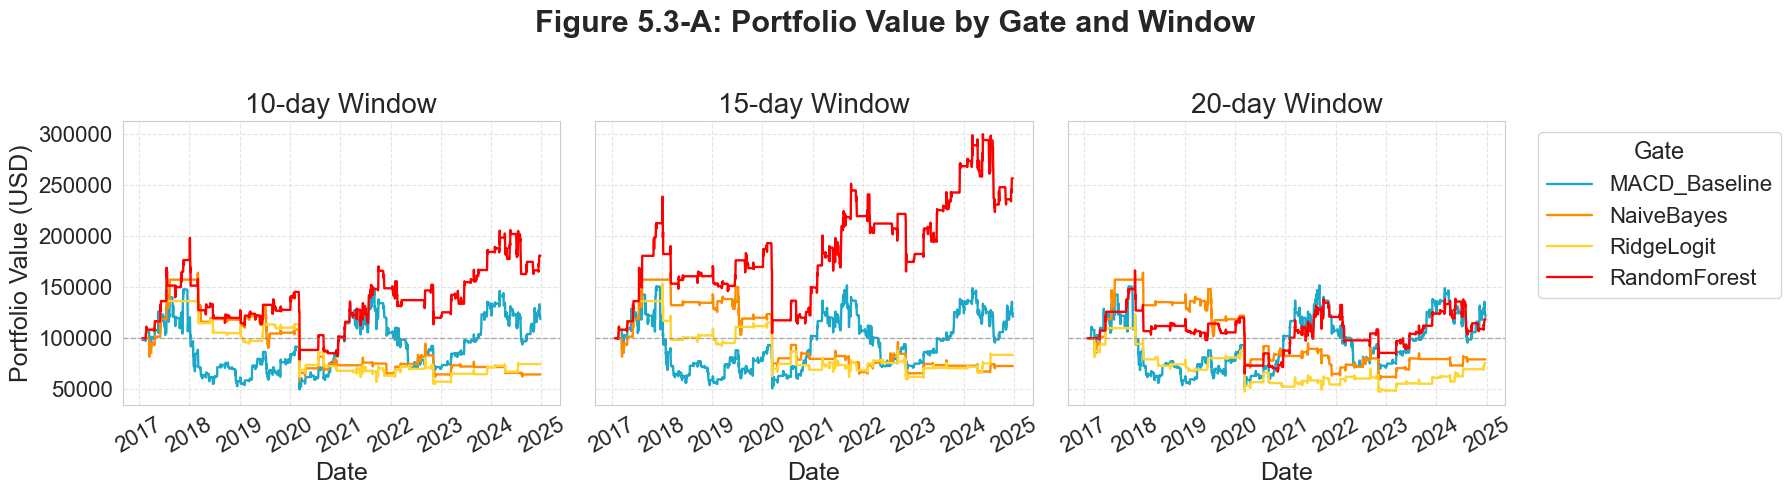

In [ ]:
# Gate color scheme (from your FPR-FNR plot)
gate_colors = {
    'MACD_Baseline': '#1CA9C9',
    'RandomForest':  '#FF0000',
    'NaiveBayes':    '#FF8C00',
    'RidgeLogit':    "#FED532",
}

# MACD windows
windows = ['10', '15', '20']   
gate_names = ['MACD_Baseline', 'NaiveBayes', 'RidgeLogit', 'RandomForest']

# Create figure with subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)
fig.suptitle("Figure 5.3-A: Portfolio Value by Gate and Window", fontsize=22, weight='bold')

for w in ['10','15','20']:
    eq = equity_curves[w]
    mask = (eq['Date'] >= common_start) & (eq['Date'] <= common_end)
    equity_curves[w] = pd.DataFrame(eq).loc[mask].reset_index(drop=True)

dates = [eq['Date'] for eq in equity_curves.values()][0]

# Loop through MACD windows
for i, window in enumerate(windows):
    ax = axes[i]
    curves = equity_curves[window]

    for gate in gate_names:
        if gate in curves:
            series = curves[gate]
            ax.plot(dates, series.values, label=gate, color=gate_colors[gate], linewidth=1.7)

    ax.set_title(f"{window}-day Window", fontsize=20)
    ax.set_xlabel("Date", fontsize=18)
    if i == 0:
        ax.set_ylabel("Portfolio Value (USD)", fontsize=18)
    ax.axhline(100_000, linestyle='--', color='gray', linewidth=1, alpha=0.6)  # Break-even reference
    ax.grid(True, linestyle='--', alpha=0.5)
    ax.tick_params(axis='x', rotation=30, labelsize=16)
    ax.tick_params(axis='y', labelsize=16)

# Legend outside the third subplot
axes[-1].legend(title="Gate", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=16, title_fontsize=17, frameon=True)

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.show()


In [11]:
series.values.shape

(2889,)

In [12]:
def calculate_max_drawdown(returns):
    """
    Calculate the maximum drawdown of a series of returns.
    
    Parameters:
    returns (pd.Series): Series of returns.
    
    Returns:
    float: Maximum drawdown.
    """
    cumulative_returns = (1 + returns).cumprod()
    peak = cumulative_returns.cummax()
    drawdown = (cumulative_returns - peak) / peak
    max_drawdown = drawdown.min()
    return max_drawdown

def calculate_hit_rate(df, signal_col='Signal', target_col=f"{H}_day_returns", threshold=0.01, trade_indices=None):
    """
    Calculate the hit rate of a trading strategy.
    
    Parameters:
    df (pd.DataFrame): DataFrame containing the signals and target returns.
    signal_col (str): Column name for the trading signal (1 for buy, -1 for sell).
    target_col (str): Column name for the target returns.
    threshold (float): Minimum return to consider a hit.
    
    Returns:
    float: Hit rate as a percentage.
    """
    hits = []
    for trade_index in trade_indices:
        if df[signal_col].iloc[trade_index] == 1:
            if df[target_col].iloc[trade_index] > threshold:
                hits.append(1)
            else:
                hits.append(0)
                
    total_trades = len(hits)
    sum_hits = sum(np.array(hits))
    
    hit_rate = sum_hits / total_trades if total_trades > 0 else 0
    return hit_rate

def calculate_mean_net(df, signal_col='Signal', target_col=f"{H}_day_returns", entry_indices=None):
    """
    Calculate the mean net return of a trading strategy.
    
    Parameters:
    df (pd.DataFrame): DataFrame containing the signals and target returns.
    signal_col (str): Column name for the trading signal (1 for buy, -1 for sell).
    target_col (str): Column name for the target returns.
    
    Returns:
    float: Mean net return.
    """
    net_returns = []
    
    for entry_index in entry_indices:
        net_return = df[target_col].iloc[entry_index]
        net_returns.append(net_return)
        
    mean_net_return = np.mean(net_returns)
    return mean_net_return

### Back-test Evaluation Table

In [13]:
records = []
index_labels = []
signal_col_mapping = {
    "NaiveBayes": 'Signal_gate_gnb',
    "RidgeLogit": 'Signal_gate_ridge',
    "RandomForest": 'Signal_gate',
    "MACD_Baseline": 'Signal_macd'
}

for window in ['10', '15', '20']:
    for gate in ["RidgeLogit", "NaiveBayes", "RandomForest"]:
        series = equity_curves[window][gate]
        
        df = portfolios[window][gate]
        indices = trade_indices[window][gate]
        
        returns = df['portfolio_value'].pct_change().dropna()
        total_return = (df['portfolio_value'].iloc[-1] / df['portfolio_value'].iloc[0]) - 1
        sharpe = calculate_sharpe_ratio(returns, annual_risk_free_rate=0.05, mode='365')
        maxdd = calculate_max_drawdown(returns)
        hitrate = calculate_hit_rate(df, signal_col=signal_col_mapping[gate], target_col=f"ret_fwd_{H}d", threshold=0, trade_indices=indices)
        meannet = calculate_mean_net(df, signal_col=signal_col_mapping[gate], target_col=f"ret_fwd_{H}d", entry_indices=indices)

        records.append([
            len(indices),
            hitrate,
            meannet,
            sharpe,
            maxdd,
            total_return
        ])
        index_labels.append(f"{window}d | {gate}")
  
records.append([
    len(trade_indices['20']['MACD_Baseline']),
    calculate_hit_rate(portfolios['20']['MACD_Baseline'], signal_col='Signal_macd', target_col=f"ret_fwd_{H}d", threshold=0, trade_indices=trade_indices['20']['MACD_Baseline']),
    calculate_mean_net(portfolios['20']['MACD_Baseline'], signal_col='Signal_macd', target_col=f"ret_fwd_{H}d", entry_indices=trade_indices['20']['MACD_Baseline']),
    calculate_sharpe_ratio(portfolios['20']['MACD_Baseline']['portfolio_value'].pct_change().dropna(), annual_risk_free_rate=0.05, mode='365'),
    calculate_max_drawdown(portfolios['20']['MACD_Baseline']['portfolio_value'].pct_change().dropna()),
    (portfolios['20']['MACD_Baseline']['portfolio_value'].iloc[-1] / portfolios['20']['MACD_Baseline']['portfolio_value'].iloc[0]) - 1
])
index_labels.append("    | MACD_Baseline")
summary = pd.DataFrame(records, columns=[
    'Trades',
    'HitRate',
    'MeanNet',
    'Sharpe',
    'MaxDD',
    'TotalReturn'
], index=index_labels)

print(summary.round(4))

                     Trades  HitRate  MeanNet  Sharpe   MaxDD  TotalReturn
10d | RidgeLogit         43   0.4884   0.0008 -0.2045 -0.6130      -0.2541
10d | NaiveBayes         45   0.5111  -0.0008 -0.2270 -0.6398      -0.3551
10d | RandomForest       76   0.5789   0.0150  0.2429 -0.6005       0.8081
15d | RidgeLogit         45   0.5333   0.0036 -0.1280 -0.6105      -0.1636
15d | NaiveBayes         45   0.5111   0.0019 -0.1670 -0.6158      -0.2723
15d | RandomForest       77   0.5844   0.0194  0.3840 -0.5596       1.5639
20d | RidgeLogit         50   0.5200   0.0018 -0.1595 -0.6146      -0.2433
20d | NaiveBayes         51   0.5098   0.0039 -0.1140 -0.6364      -0.2075
20d | RandomForest       74   0.5270   0.0095  0.0640 -0.6064       0.1857
    | MACD_Baseline     152   0.5395   0.0081  0.1656 -0.6627       0.2095
